#                                Sensor Component Failure Prediction Using ANN and ML Algorithms


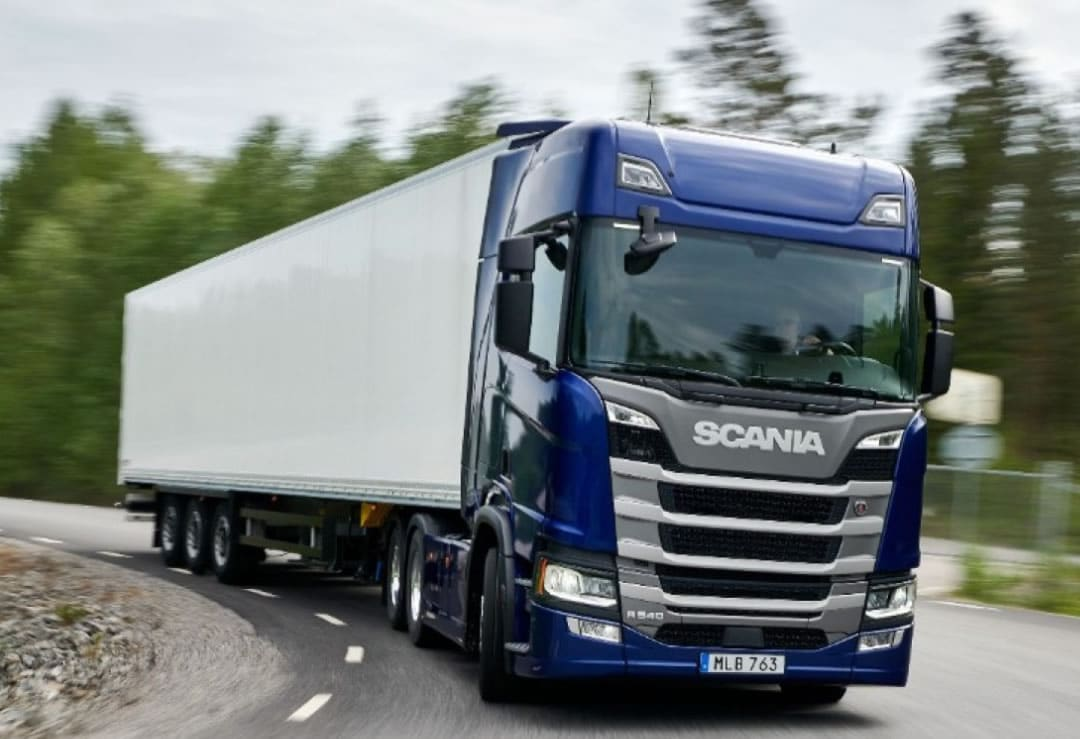

In [ ]:
from IPython import display
display.Image("https://www.sabo.it/wp-content/uploads/2020/11/scaniar540.jpg",width=500)

## 1) Problem statement.

**Data:** Sensor Data

**Problem statement :**
- The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

- The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

|True class | Positive | Negative | |
| ----------- | ----------- |   |  |
|<b>Predicted class</b>||| |
| Positive      |   -       | cost_1  |    |
| Negative   | cost_2        |  | |


Cost 1 = 10 and Cost 2 = 500

- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of Instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case `Cost_1` refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while `Cost_2` refer to the cost of missing a faulty truck, which may cause a breakdown. 
- `Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.`

- From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to **reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.**

## Challenges and other objectives

- Need to Handle many Null values in almost all columns
- No low-latency requirement.
- Interpretability is not important.
- misclassification leads the unecessary repair costs.

## 2) Import required libraries

In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

### Read Data

In [ ]:
# Load csv file
df = pd.read_csv('https://raw.githubusercontent.com/sunnysavita10/deep-learning/main/aps_data.csv', na_values="na")

In [ ]:
# check rows and columns of the dataset
df.shape

(5000, 171)

In [ ]:
# Check unique values of target varaible
df['class'].value_counts()

neg    4909
pos      91
Name: class, dtype: int64

In [ ]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

### As this is a Sensor data. Interpretation of the data is not required 

### Checking missing values

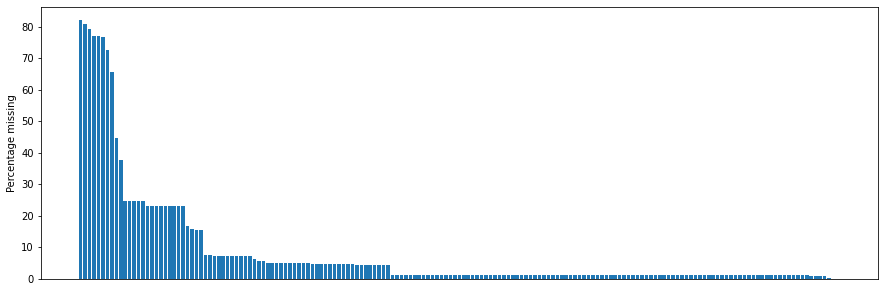

In [ ]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

### Dropping Columns which has more than 70% of missing values.

In [ ]:
## Dropping columns which has more than 70% of missing values
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,82.10
bq_000,80.86
bp_000,79.20
ab_000,76.98
cr_000,76.98
bo_000,76.64
bn_000,72.62


In [ ]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [ ]:
# Check shape of the dataset after dropping columns
df.shape

(5000, 164)

In [ ]:
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 5.412195121951219%


## Visualization of unique values in Target variable

Positive: 91, Negative: 4909


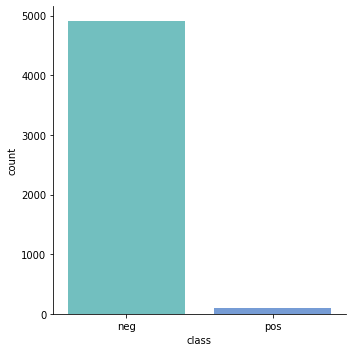

In [ ]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=.6)
plt.show()

**Report**
- The target classes are highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. 
- Hence we should handle imbalanced data with certain methods.

**How to handle Imbalance Data ?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

## Create Functions for model training and evaluation

In [ ]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [ ]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [ ]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

### Plot  distribution of all Independent Numerical variables

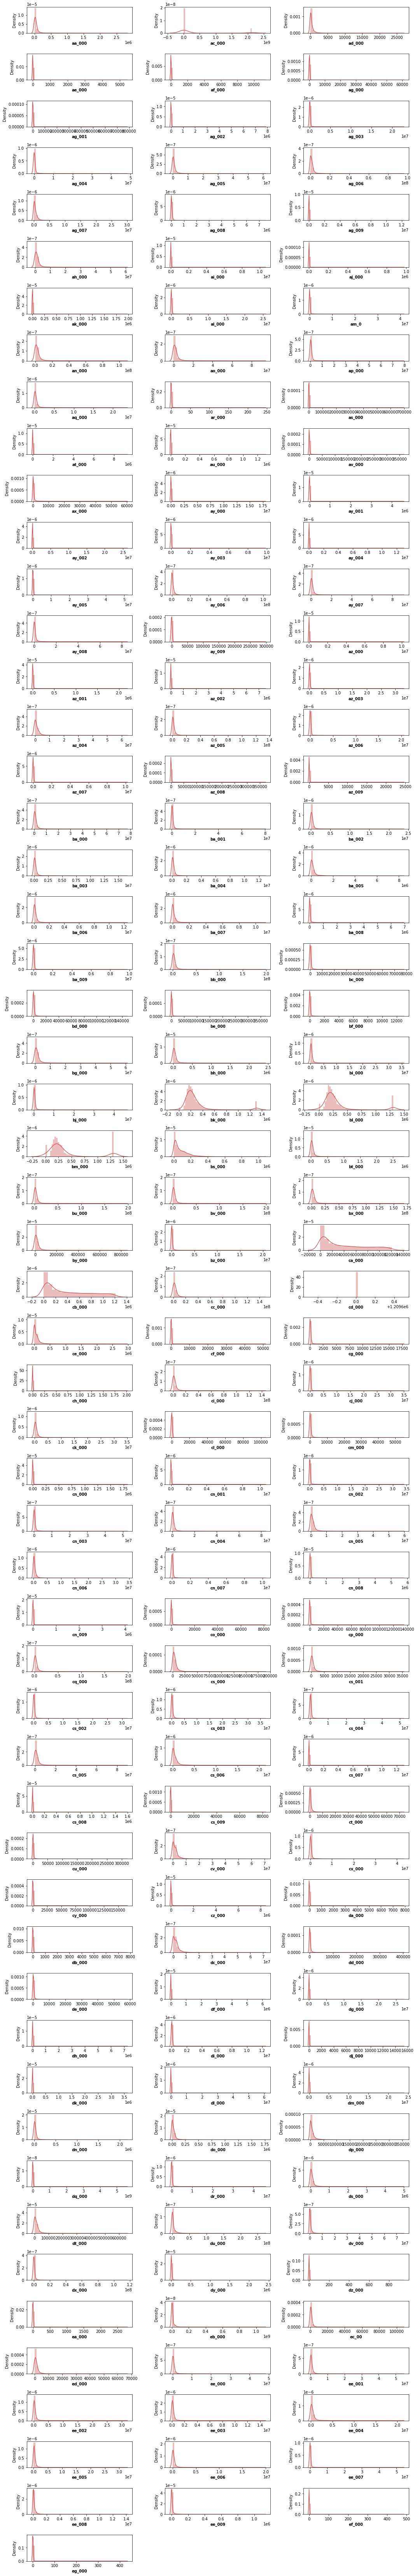

In [ ]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

**Report**
- As per the above plot most of the features are not normally distributed.
- Transformation of data is not of prime importance since it is a classification problem.
- Interpreting each and every column is not necessary as this is sensor data.

# Evaluate Model on Different experiments

In [ ]:
# Splitting X and y for all Experiments
X= df.drop('class', axis=1)
y = df['class']

- **Manually Encoding Target Variable**

In [ ]:
y= y.replace({'pos': 1, 'neg': 0})

### Experiment: 1 = KNN Imputer for Null values

**Why Robust scaler and not Standard scaler?**
- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

**Why Robust Scaler and not Minmax?** 
- because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [ ]:
# Fit with robust scaler for KNN best K-selection experminet
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

**Why KNN Imputer**?
- KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
- Here we Iterates through different K values and get accuracy and choose best K values.

**Finding the optimal n_neighbour value for KNN imputer**

In [ ]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.7602)
n_neighbors= 3 || accuracy (0.7342)
n_neighbors= 5 || accuracy (0.7488)
n_neighbors= 7 || accuracy (0.7232)
n_neighbors= 9 || accuracy (0.7244)


**We can observe n_neighbors=3 able to produce highest accuracy**

### Pipeline for KNN imputer

In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_knn =knn_pipeline.fit_transform(X)

## Handling Imbalanced data

 **SMOTE+TOMEK** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
 
 - This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class
 
 - To add new data of minority class
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.
 
 - To remove the tomek links of the majority class
 1. Choose random data from the majority class.
 2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
 
 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [ ]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

### Initialize Default Models in a dictionary

In [ ]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

### Fit KNN imputed data for models in dictionary

In [ ]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9882
- F1 score: 0.9881
- Precision: 0.9846
- Recall: 0.9917
- Roc Auc Score: 0.9883
- COST: 4150.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9852
- F1 score: 0.9850
- Precision: 0.9845
- Recall: 0.9855
- Roc Auc Score: 0.9852
- COST: 7150.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9978
- F1 score: 0.9978
- Precision: 0.9972
- Recall: 0.9985
- Roc Auc Score: 0.9978
- COST: 3110.
----------------------------------
Model performance for Test set
- Accuracy: 0.9867
- F1 score: 0.9866
- Precision: 0.9796
- Recall: 0.9938
- Roc Auc Sco

### Report for KNN Imputed data

In [ ]:
report_knn

,Model Name,Cost
6,CatBoosting Classifier,120
5,XGBClassifier,580
2,Gradient Boosting,3200
0,Random Forest,4150
7,AdaBoost Classifier,5730
1,Decision Tree,7150
4,K-Neighbors Classifier,7550
3,Logistic Regression,12520


**Insights**
- For the Experiment 1: Knn imputer has XGBoost classifier as the best Model
- Proceeding with further experiments 

### Experiment: 2 = Simple Imputer with Strategy Median 

- SimpleImputer is a class in the `sklearn.impute` module that can be used to replace missing values in a dataset, using a variety of input strategies.
- Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [ ]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9928
- F1 score: 0.9927
- Precision: 0.9885
- Recall: 0.9968
- Roc Auc Score: 0.9929
- COST: 1610.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9861
- F1 score: 0.9859
- Precision: 0.9783
- Recall: 0.9937
- Roc Auc Score: 0.9863
- COST: 3210.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9969
- F1 score: 0.9969
- Precision: 0.9962
- Recall: 0.9977
- Roc Auc Score: 0.9969
- COST: 4650.
----------------------------------
Model performance for Test set
- Accuracy: 0.9902
- F1 score: 0.9901
- Precision: 0.9844
- Recall: 0.9958
- Roc Auc Sco

## Report for Simple Imputer with median strategy

In [ ]:
report_median

,Model Name,Cost
5,XGBClassifier,110
6,CatBoosting Classifier,130
0,Random Forest,1610
2,Gradient Boosting,2150
1,Decision Tree,3210
7,AdaBoost Classifier,4160
4,K-Neighbors Classifier,6580
3,Logistic Regression,31070


**Insights**
- For the Experiment 2: Simple imputer with median strategy has Catboost classifier as the best Model
- Proceeding with further experiments 

### Experiment: 3 = MICE for Imputing Null values

- MICE stands for Multivariate Imputation By Chained Equations algorithm
- This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.
- `ImputationKernel` Creates a kernel dataset. This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

In [ ]:
pip install miceforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.7 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [ ]:
X_mice = kernel.complete_data()

In [ ]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with Mice imputer 
X_mice= mice_pipeline.fit_transform(X_mice)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [ ]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9938
- F1 score: 0.9937
- Precision: 0.9906
- Recall: 0.9968
- Roc Auc Score: 0.9939
- COST: 1590.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9882
- F1 score: 0.9880
- Precision: 0.9844
- Recall: 0.9916
- Roc Auc Score: 0.9882
- COST: 4150.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9985
- F1 score: 0.9985
- Precision: 0.9969
- Recall: 1.0000
- Roc Auc Score: 0.9984
- COST: 120.
----------------------------------
Model performance for Test set
- Accuracy: 0.9902
- F1 score: 0.9901
- Precision: 0.9854
- Recall: 0.9947
- Roc Auc Scor

## Report for MICE Imputer algorithm

In [ ]:
report_mice

,Model Name,Cost
5,XGBClassifier,1090
6,CatBoosting Classifier,1100
0,Random Forest,1590
2,Gradient Boosting,2640
1,Decision Tree,4150
7,AdaBoost Classifier,6170
4,K-Neighbors Classifier,16480
3,Logistic Regression,24350


**Insights**
- For the Experiment 3: Mice imputer has XGBoost classifier as the best Model
- Proceeding with further experiments 

### Experiment: 4 = Simple Imputer with Strategy Constant 

- Another strategy which can be used is replacing missing values with a fixed (constant) value.
- To do this, specify “constant” for strategy and specify the fill value using the fill_value parameter

In [ ]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_const =constant_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [ ]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9907
- F1 score: 0.9906
- Precision: 0.9813
- Recall: 1.0000
- Roc Auc Score: 0.9910
- COST: 180.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9907
- F1 score: 0.9905
- Precision: 0.9843
- Recall: 0.9968
- Roc Auc Score: 0.9909
- COST: 1650.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9974
- F1 score: 0.9975
- Precision: 0.9954
- Recall: 0.9995
- Roc Auc Score: 0.9974
- COST: 1180.
----------------------------------
Model performance for Test set
- Accuracy: 0.9887
- F1 score: 0.9885
- Precision: 0.9792
- Recall: 0.9979
- Roc Auc Scor

## Report for Simple Imputer with Constant strategy

In [ ]:
report_const

,Model Name,Cost
5,XGBClassifier,120
6,CatBoosting Classifier,160
0,Random Forest,180
2,Gradient Boosting,1200
1,Decision Tree,1650
7,AdaBoost Classifier,2680
4,K-Neighbors Classifier,11110
3,Logistic Regression,12380


**Insights**
- For the Experiment 4: Simple imputer with constant strategy has XGBoost classifier as the best Model
- Proceeding with further experiments 

## Experiment: 5 = Simple Imputer with Strategy Mean 

- Another strategy which can be used is replacing missing values with mean
- Here we replace the missing values with the mean of the column

In [ ]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_mean = mean_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

In [ ]:
# Training all models
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9943
- F1 score: 0.9943
- Precision: 0.9896
- Recall: 0.9990
- Roc Auc Score: 0.9944
- COST: 600.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9825
- F1 score: 0.9824
- Precision: 0.9723
- Recall: 0.9927
- Roc Auc Score: 0.9827
- COST: 3770.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9982
- F1 score: 0.9982
- Precision: 0.9972
- Recall: 0.9992
- Roc Auc Score: 0.9982
- COST: 1610.
----------------------------------
Model performance for Test set
- Accuracy: 0.9897
- F1 score: 0.9896
- Precision: 0.9824
- Recall: 0.9969
- Roc Auc Scor

### Report for Simple imputer with strategy mean

In [ ]:
report_mean

,Model Name,Cost
0,Random Forest,600
5,XGBClassifier,610
6,CatBoosting Classifier,640
2,Gradient Boosting,1670
7,AdaBoost Classifier,2650
1,Decision Tree,3770
4,K-Neighbors Classifier,11580
3,Logistic Regression,65780


### Experiment: 5 = Principle component analysis with imputing median

- Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! 
- As the dataset has 164 columns we can try PCA and check our metrics Cost

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_pca = pca_pipeline.fit_transform(X)

In [ ]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

**Variance Plot**

<AxesSubplot:>

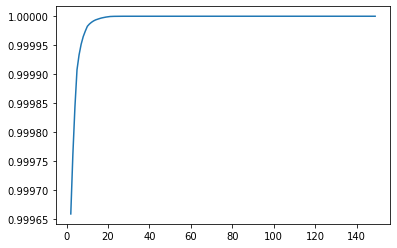

In [ ]:
# plotting variance ratio
pd.Series(var_ratio).plot()

**Kneed algorithm to find the elbow point**

In [ ]:
!pip install --upgrade kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Figure size 360x360 with 0 Axes>

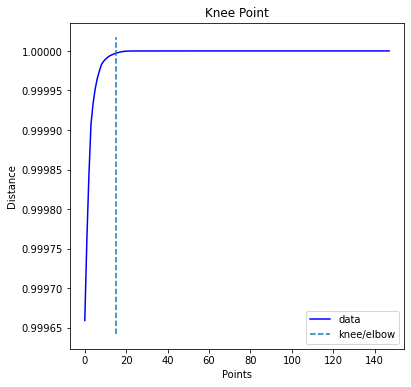

Knee Locator k = 17


In [ ]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [ ]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

In [ ]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9997
- Roc Auc Score: 0.9999
- COST: 500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9756
- F1 score: 0.9752
- Precision: 0.9665
- Recall: 0.9840
- Roc Auc Score: 0.9759
- COST: 7820.


Decision Tree
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9997
- Roc Auc Score: 0.9999
- COST: 500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9668
- F1 score: 0.9662
- Precision: 0.9562
- Recall: 0.9765
- Roc Auc Score: 0.9671
- COST: 11420.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9737
- F1 score: 0.9741
- Precision: 0.9649
- Recall: 0.9835
- Roc Auc Score: 0.9736
- COST: 33390.
----------------------------------
Model performance for Test set
- Accuracy: 0.9611
- F1 score: 0.9605
- Precision: 0.9481
- Recall: 0.9733
- Roc A

### Report for PCA and Mean imputed data

In [ ]:
report_pca

,Model Name,Cost
6,CatBoosting Classifier,7810
0,Random Forest,7820
5,XGBClassifier,8270
1,Decision Tree,11420
4,K-Neighbors Classifier,12620
2,Gradient Boosting,13000
7,AdaBoost Classifier,21140
3,Logistic Regression,99760


## Final Model

In [ ]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","2950"])
pt.add_row(["XGBClassifier","Mice","3510"])
pt.add_row(["XGBClassifier","Knn-Imputer","4460"])
pt.add_row(["XGBClassifier","Simple Imputer-Mean","4950"])
pt.add_row(["CatBoostClassifier","Median","5760"])
pt.add_row(["Random Forest","PCA","34150"])
print(pt)

+--------------------+-------------------------+------------+
|       Model        |    Imputation_method    | Total_cost |
+--------------------+-------------------------+------------+
|   XGBClassifier    | Simple Imputer-Constant |    2950    |
|   XGBClassifier    |           Mice          |    3510    |
|   XGBClassifier    |       Knn-Imputer       |    4460    |
|   XGBClassifier    |   Simple Imputer-Mean   |    4950    |
| CatBoostClassifier |          Median         |    5760    |
|   Random Forest    |           PCA           |   34150    |
+--------------------+-------------------------+------------+


**Report**
- From the final report we can see than XGBClassifier with Simple imputer with strategy constant has performed the best with cost of 2950

### Fitting the Final model and get reports

In [ ]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [ ]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 1.0
Final XGBoost Classifier Accuracy Score (Test) : 0.9938271604938271


In [ ]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 120


In [ ]:
pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


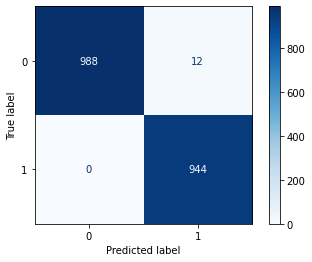

In [ ]:
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


#plots Confusion matrix
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='Blues', values_format='d')

## The best Model is XGBoost Classifier with 99.6% accuracy and cost of 2950

In [ ]:
#@title ANN Implementation


In [ ]:
X_train, X_test, y_train, y_test 

(array([[ 2.95433674e+01,  6.39855825e+00,  1.71376414e+01, ...,
          2.12434022e+02,  0.00000000e+00,  0.00000000e+00],
        [ 1.54469969e+01, -1.48286604e-01, -1.44736842e-01, ...,
          9.75504891e+01,  0.00000000e+00,  0.00000000e+00],
        [ 1.69928318e+01, -1.48286604e-01,  7.20032363e+00, ...,
          9.78851256e-03,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.79828442e+01,  1.84433472e-01,  6.66484958e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.58302286e-01,  1.93146417e-01,  6.44736842e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.39740791e+01, -1.48286604e-01, -1.44736842e-01, ...,
          1.74119178e+01,  0.00000000e+00,  0.00000000e+00]]),
 array([[ 5.06373980e-01,  7.01557632e-01,  1.37500000e+00, ...,
          2.12817412e-02,  0.00000000e+00,  0.00000000e+00],
        [ 7.70950778e+00, -1.48286604e-01, -1.44736842e-01, ...,
          2.68697980e+00,  0.00000000e

In [ ]:
# Importing the Keras libraries and packages
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [ ]:
classifier=Sequential()

classifier.add(Dense(units=10,kernel_initializer='he_uniform',activation='relu',input_dim =163))

classifier.add(Dense(units = 10, kernel_initializer = 'he_uniform',activation='relu'))
 
classifier.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [ ]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                1640      
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=classifier.fit(X_train,y_train,batch_size=10,epochs=30,validation_split=0.25)

Epoch 1/30
583/583 [==============================] - 8s 4ms/step - loss: 135109.3438 - accuracy: 0.7310 - val_loss: 48499.4258 - val_accuracy: 0.7962
Epoch 2/30
583/583 [==============================] - 3s 4ms/step - loss: 63958.6836 - accuracy: 0.8116 - val_loss: 42774.3516 - val_accuracy: 0.8348
Epoch 3/30
583/583 [==============================] - 2s 4ms/step - loss: 41589.0352 - accuracy: 0.8238 - val_loss: 88596.5234 - val_accuracy: 0.8163
Epoch 4/30
583/583 [==============================] - 3s 5ms/step - loss: 52405.0312 - accuracy: 0.8356 - val_loss: 8097.0361 - val_accuracy: 0.8569
Epoch 5/30
583/583 [==============================] - 2s 4ms/step - loss: 19620.2871 - accuracy: 0.8487 - val_loss: 26906.5996 - val_accuracy: 0.8513
Epoch 6/30
583/583 [==============================] - 2s 4ms/step - loss: 35954.8906 - accuracy: 0.8471 - val_loss: 131626.2656 - val_accuracy: 0.8250
Epoch 7/30
583/583 [==============================] - 3s 4ms/step - loss: 39539.4492 - accuracy: 0.

In [ ]:
model_history.history.keys()
     

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model_history.history['accuracy']

[0.7310001850128174,
 0.8116315007209778,
 0.823811948299408,
 0.835649311542511,
 0.8486875891685486,
 0.8471435904502869,
 0.8471435904502869,
 0.8455995917320251,
 0.8728770017623901,
 0.882655680179596,
 0.8754503130912781,
 0.8893463611602783,
 0.8867730498313904,
 0.8903757333755493,
 0.8841996788978577,
 0.8898610472679138,
 0.886944591999054,
 0.8787099123001099,
 0.8843712210655212,
 0.8898610472679138,
 0.8814547657966614,
 0.8836850523948669,
 0.8922628164291382,
 0.8687596321105957,
 0.8785383701324463,
 0.8745925426483154,
 0.8605249524116516,
 0.8663578629493713,
 0.8677303194999695,
 0.8572654128074646]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


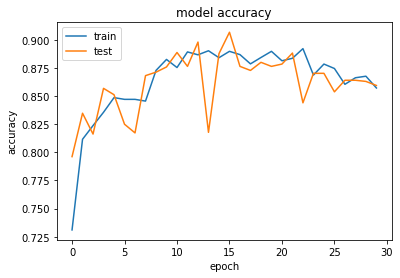

In [ ]:
# list all data in history

print(model_history.history.keys())
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

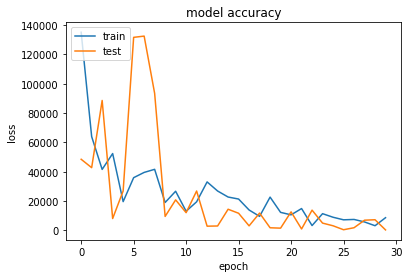

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_test.shape

(1944, 163)

In [ ]:
y_pred=classifier.predict(X_test)

61/61 [==============================] - 0s 3ms/step


In [ ]:
#for the sigmoid my threshold is 0.
     

y_pred=y_pred>0.5
     


In [ ]:
from sklearn.metrics import confusion_matrix
     

y_test.shape,  y_pred.shape

((1944,), (1944, 1))

In [ ]:
confusion_matrix(y_test,y_pred)

array([[837, 163],
       [102, 842]])

In [ ]:
import time
import os

def saveModel_path(model_dir="SAVED_MODELS"):
    os.makedirs(model_dir, exist_ok=True)
    fileName = time.strftime("Model_%Y_%m_%d_%H_%M_%S_.h5")    
    model_path = os.path.join(model_dir, fileName)
    print(f"your model will be saved at the following location\n{model_path}")
    return model_path
     

In [ ]:
classifier.save(saveModel_path())

your model will be saved at the following location
SAVED_MODELS/Model_2023_03_07_08_09_04_.h5


In [ ]:
#hyperparameter tunig with keras tuner

!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.0 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch
     

In [ ]:
def build_model(hp):
  model=Sequential()
  model.add(Dense(units=32,kernel_initializer = 'he_uniform',activation='relu',input_dim=163))
  model.add(Dense(units = 32, kernel_initializer = 'he_uniform',activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  optimizer=hp.Choice("optimizer",values=["adam","sgd","rmsprop","adadelta"])
  model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
tuner=RandomSearch(build_model,objective='val_accuracy',max_trials=5,directory='project1',project_name='aps-fault')
     

In [ ]:
tuner.search(X_train,y_train,validation_data=(X_test,y_test),epochs=5)
     

Trial 4 Complete [00h 00m 09s]
val_accuracy: 0.883230447769165

Best val_accuracy So Far: 0.9130658507347107
Total elapsed time: 00h 00m 35s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'optimizer': 'rmsprop'}

In [ ]:
mymodel=tuner.get_best_models(num_models=1)[0]
     

In [ ]:
mymodel.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                5248      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner_second=RandomSearch(build_model,objective='val_accuracy',max_trials=5,directory='project3',project_name='aps-fault-sensor')
     


In [ ]:
tuner_second.search(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Trial 5 Complete [00h 00m 15s]
val_accuracy: 0.8816872239112854

Best val_accuracy So Far: 0.8816872239112854
Total elapsed time: 00h 01m 44s


In [ ]:
tuner_second.get_best_hyperparameters()[0].values
     

{'num_layers': 12,
 'units_0': 480,
 'units_1': 96,
 'learning_rate': 0.0001,
 'units_2': 352,
 'units_3': 384,
 'units_4': 448,
 'units_5': 64,
 'units_6': 288,
 'units_7': 256,
 'units_8': 320,
 'units_9': 64,
 'units_10': 416,
 'units_11': 160,
 'units_12': 480,
 'units_13': 448,
 'units_14': 192}

In [ ]:
classifier2=tuner_second.get_best_models(num_models=1)[0]

In [ ]:

classifier2.summary
     

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f7b92c36220>>